In [1]:
!pip install numpy tensorly pillow matplotlib


In [2]:
!pip install --upgrade tensorly


In [3]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import tensor_train
from tensorly.tt_tensor import tt_to_tensor
from PIL import Image
import matplotlib.pyplot as plt

class TTDecomposition:
    def __init__(self, max_rank=10):
        self.max_rank = max_rank
        self.tt_cores = None

    def decompose(self, image):
        self.original_shape = image.shape
        tensor = image / 255.0  # Нормализация изображения
        self.tt_cores = tensor_train(tensor, rank=self.max_rank)
        return self.tt_cores

    def reconstruct(self):
        if self.tt_cores is None:
            raise ValueError("Сначала выполните разложение `decompose`.")
        
        tensor = tt_to_tensor(self.tt_cores)
        tensor = np.clip(tensor * 255, 0, 255).astype(np.uint8)  # Обратно к диапазону 0-255
        return tensor
    def get_compressed_size(self):
        if self.tt_cores is None:
            raise ValueError("Сначала выполните разложение с помощью метода `decompose`.")

        total_size = sum(core.nbytes for core in self.tt_cores)
        return total_size


def load_image(filepath):
    image = Image.open(filepath).convert('L')  # Градации серого для упрощения
    return np.array(image)

def save_image(image, filepath):
    img = Image.fromarray(image)
    img.save(filepath)

def show_images(original, reconstructed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed, cmap='gray')
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    filepath = "C:\\Users\\Admin\\OneDrive\\Рабочий стол\\nla\\project\\img\\test.png"
    image = load_image(filepath)
    original_size = image.nbytes

    tt_decomposer = TTDecomposition(max_rank=10)
    tt_decomposer.decompose(image)
    reconstructed_image = tt_decomposer.reconstruct()
    tt_compressed_size = tt_decomposer.get_compressed_size()

    show_images(image, reconstructed_image)
    print(f"Original Image Size: {original_size / 1024:.2f} KB")
    print(f"Comp Image Size: {tt_compressed_size / 1024:.2f} KB")


Original Image Size: 89.06 KB
Comp Image Size: 48.44 KB


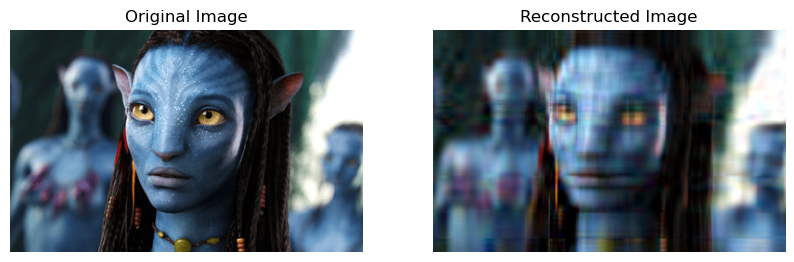

In [4]:
import sys
import numpy as np
import tensorly as tl
from tensorly.decomposition import tensor_train
from tensorly.tt_tensor import tt_to_tensor
from PIL import Image
import matplotlib.pyplot as plt

def calculate_tt_size(tt_cores):
    total_size = sum(core.nbytes for core in tt_cores)
    return total_size


class TTDecompositionColor:
    def __init__(self, max_rank=10):
        self.max_rank = max_rank
        self.tt_cores = {'R': None, 'G': None, 'B': None}
        self.original_shape = None

    def decompose(self, image):
        self.original_shape = image.shape
        self.tt_cores = {
            'R': tensor_train(image[:, :, 0] / 255.0, rank=self.max_rank),
            'G': tensor_train(image[:, :, 1] / 255.0, rank=self.max_rank),
            'B': tensor_train(image[:, :, 2] / 255.0, rank=self.max_rank),
        }

    def reconstruct(self):
        if not self.tt_cores['R'] or not self.tt_cores['G'] or not self.tt_cores['B']:
            raise ValueError("Сначала выполните разложение с помощью метода `decompose`.")

        r_channel = tt_to_tensor(self.tt_cores['R']) * 255.0
        g_channel = tt_to_tensor(self.tt_cores['G']) * 255.0
        b_channel = tt_to_tensor(self.tt_cores['B']) * 255.0

        reconstructed = np.stack(
            [np.clip(r_channel, 0, 255), 
             np.clip(g_channel, 0, 255), 
             np.clip(b_channel, 0, 255)],
            axis=2
        ).astype(np.uint8)
        return reconstructed
    
    def get_compressed_size(self):
        if not self.tt_cores['R'] or not self.tt_cores['G'] or not self.tt_cores['B']:
            raise ValueError("Сначала выполните разложение с помощью метода `decompose`.")

        size_r = calculate_tt_size(self.tt_cores['R'])
        size_g = calculate_tt_size(self.tt_cores['G'])
        size_b = calculate_tt_size(self.tt_cores['B'])

        return size_r + size_g + size_b

def load_color_image(filepath):
    image = Image.open(filepath).convert('RGB')  # Цветное изображение
    return np.array(image)

def save_color_image(image, filepath):
    img = Image.fromarray(image)
    img.save(filepath)

def show_color_images(original, reconstructed):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed)
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    filepath = "C:\\Users\\Admin\\OneDrive\\Рабочий стол\\nla\\project\\img\\test.png"
    image = load_color_image(filepath)

    tt_decomposer = TTDecompositionColor(max_rank=10)
    tt_decomposer.decompose(image)

    reconstructed_image = tt_decomposer.reconstruct()
    show_color_images(image, reconstructed_image)
